In [1]:
### Library

In [79]:
import re
import os
import json
import numpy as np
import pandas as pd
from pprint import pprint
import seaborn as sns

# NLTK Stop words
import nltk
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer

# spacy for lemmatization
import spacy

#remove urls, mentions, emojis 
import preprocessor as p

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  
import matplotlib.pyplot as plt

In [3]:
filepath = '/Users/lavine/Desktop/Terriers!/misinformation project/data/data.txt'

### Create a dataframe by every columns

In [4]:
#load all the JSON objects in one list as dictionaries
data = []
with open(filepath,'r') as f:
    for line in f:
        data.append(json.loads(line))

 #### Put the text data in one list

In [5]:
lst_o_text = []

#create lists for id, author id and conversation
lst_id = []
lst_lang = []
lst_author_id = []
lst_conversation_id = []

#lst verified or not, author name and author username
lst_author_verified = []
lst_author_name = []
lst_author_username = []

#list creation time
lst_twt_creation_time = []

for i in data:
    if not 'referenced_tweets' in i:
        lst_o_text.append(i['text'])
        lst_id.append(i['id'])
        lst_lang.append(i['lang'])
        lst_author_id.append(i['author_id'])
        lst_conversation_id.append(i['conversation_id'])
        lst_author_verified.append(i['author']['verified'])
        lst_author_name.append(i['author']['name'])
        lst_author_username.append(i['author']['username'])
        lst_twt_creation_time.append(i['created_at'])

 #### Put the author info in list

In [6]:
data[0].keys()

dict_keys(['lang', 'id', 'possibly_sensitive', 'author_id', 'text', 'referenced_tweets', 'created_at', 'source', 'entities', 'in_reply_to_user_id', 'reply_settings', 'conversation_id', 'public_metrics', 'author', 'in_reply_to_user', '__twarc'])

##### Put what we have in one dataframe

In [7]:
tweets = pd.DataFrame({'text': lst_o_text,
                  'language': lst_lang,
                  'id': lst_id,
                  'author_id': lst_author_id,
                  'conversation_id': lst_conversation_id,
                  'author_verified': lst_author_verified,
                  'author_name': lst_author_name,
                  'author_username': lst_author_username,
                  'twt_creation_time': lst_twt_creation_time
                  })

In [8]:
pd.set_option("display.max_colwidth", 10000)

In [9]:
tweets.drop(tweets[tweets['language'] != 'en'].index, inplace = True)

In [10]:
tweets.head()

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time
0,"'We are in a climate emergency'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn't going 2save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!",en,1477024401254092800,1009831809855688707,1477024401254092800,False,Vammek Opinion,Vammek,2021-12-31T21:10:33.000Z
1,"#Oil business knows about the damage that It does, but this business is too much easy and lucrative https://t.co/W7MemjJAA9 #FossilFuels \nExxon’s Plan for Surging Carbon Emissions Revealed in Leaked Documents https://t.co/RFX8meYv11",en,1476991564803104776,590788952,1476991564803104776,False,Robert Pujol i Vives,rpujolvives,2021-12-31T19:00:04.000Z
2,@amywestervelt Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.,en,1476962302159060992,1476958634705780736,1476962302159060992,False,Megan Robbins,MeganRo50852817,2021-12-31T17:03:48.000Z
3,"Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign this petition to pressure the Senate to END fossil fuel subsidies https://t.co/2A7wLyid3X?",en,1476954565450903553,47878087,1476954565450903553,False,Jennifer Hall,JDHall_35402,2021-12-31T16:33:03.000Z
4,"Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign our petition to pressure the Senate to END fossil fuel subsidies https://t.co/OD7YqPO5SP?",en,1476922966893948928,1450838788037496836,1476922966893948928,False,Dennis Landi,DennisLandi2,2021-12-31T14:27:29.000Z


### Data preprocessing

In [11]:
tweets['hashtag'] = tweets['text'].apply(lambda x: re.findall(r"#(\w+)", x))

In [12]:
#forming a separate column for cleaned tweets
tweets['ctext'] = tweets['text'].apply(lambda x: p.clean(x))

In [13]:
tweets.head(3)

,text,language,id,author_id,conversation_id,author_verified,author_name,author_username,twt_creation_time,hashtag,ctext
0,"'We are in a climate emergency'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn't going 2save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!",en,1477024401254092800,1009831809855688707,1477024401254092800,False,Vammek Opinion,Vammek,2021-12-31T21:10:33.000Z,[],"'We are in a climate emergency'December wildfires ravage Colorado Sen. Manchin, your Exxon highway bill isn't going save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!"
1,"#Oil business knows about the damage that It does, but this business is too much easy and lucrative https://t.co/W7MemjJAA9 #FossilFuels \nExxon’s Plan for Surging Carbon Emissions Revealed in Leaked Documents https://t.co/RFX8meYv11",en,1476991564803104776,590788952,1476991564803104776,False,Robert Pujol i Vives,rpujolvives,2021-12-31T19:00:04.000Z,"[Oil, FossilFuels]","business knows about the damage that It does, but this business is too much easy and lucrative Exxons Plan for Surging Carbon Emissions Revealed in Leaked Documents"
2,@amywestervelt Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.,en,1476962302159060992,1476958634705780736,1476962302159060992,False,Megan Robbins,MeganRo50852817,2021-12-31T17:03:48.000Z,[],Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.


In [14]:
#convert to list
ctext = tweets['ctext'].tolist()

In [71]:
nctext = tweets['text'].tolist()
tweetid = tweets['id'].tolist()
authorid = tweets['author_id'].tolist()
authorname = tweets['author_name'].tolist()
authorusername = tweets['author_username'].tolist()

In [16]:
# Remove new line characters
ctext = [re.sub('\s+', ' ', sent) for sent in ctext]

<>:2: DeprecationWarning: invalid escape sequence \s
<>:2: DeprecationWarning: invalid escape sequence \s
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_48789/1351202947.py:2: DeprecationWarning: invalid escape sequence \s
  ctext = [re.sub('\s+', ' ', sent) for sent in ctext]


In [17]:
# Remove distracting single quotes
ctext = [re.sub("\'", "", sent) for sent in ctext]

In [18]:
# remove punctuations
ctext = [re.sub(r'[^\w\s]', '', sent) for sent in ctext]

In [19]:
ctext[1:5]

['business knows about the damage that It does but this business is too much easy and lucrative Exxons Plan for Surging Carbon Emissions Revealed in Leaked Documents',
 'Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back',
 'Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign this petition to pressure the Senate to END fossil fuel subsidies ',
 'Each year the government gives over 15 billion in taxpayerfunded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon Will you sign our petition to pressure the Senate to END fossil fuel subsidies ']

### Tokenize words and further clean up text

Tokenize each sentence into a list of words, removing punctuations and unnecessary characters altoghter

In [20]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

tweet_words = list(sent_to_words(ctext))

print(tweet_words[:1])

[['we', 'are', 'in', 'climate', 'wildfires', 'ravage', 'colorado', 'sen', 'manchin', 'your', 'exxon', 'highway', 'bill', 'isnt', 'going', 'save', 'our', 'homes', 'or', 'our', 'lives', 'your', 'greed', 'amp', 'corruption', 'is', 'not', 'only', 'torching', 'our', 'future', 'its', 'burning', 'our', 'communities', 'and', 'destroying', 'lives']]


In [21]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(tweet_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[tweet_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[tweet_words[0]]])

['we', 'are', 'in', 'climate', 'wildfires', 'ravage', 'colorado', 'sen_manchin', 'your', 'exxon', 'highway', 'bill', 'isnt', 'going', 'save', 'our', 'homes', 'or', 'our', 'lives', 'your', 'greed', 'amp', 'corruption', 'is', 'not', 'only', 'torching', 'our', 'future', 'its', 'burning', 'our', 'communities', 'and', 'destroying', 'lives']


### Remove Stopwords, Make Bigrams and Lemmatize

In [22]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu'])

In [23]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

In [24]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [25]:
# Remove Stop Words
tweet_words_nostops = remove_stopwords(tweet_words)

In [26]:
# Form Bigrams
tweet_words_bigrams = make_bigrams(tweet_words_nostops)

In [27]:
# Initialize spacy 'en_core_web_sm' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en_core_web_sm
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])# not "en" any more

# Do lemmatization keeping only noun, adj, vb, adv
tweet_lemmatized = lemmatization(tweet_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(tweet_lemmatized[:1])

[['climate', 'wildfire', 'ravage', 'highway', 'bill', 'go', 'save', 'home', 'live', 'greed', 'amp', 'corruption', 'torch', 'future', 'burn', 'community', 'destroy', 'life']]


### Creat the dictionary and the corpus

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(tweet_lemmatized)

# Create Corpus
texts = tweet_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts] 

#Gensim creates a unique id for each word in the document. 
#The produced corpus shown below is a mapping of (word_id, word_frequency(times of occurance)).

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [29]:
id2word[40]

'inspire'

In [30]:
#If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.
id2word[4]

#input of LDA

'community'

In [31]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('amp', 1),
  ('bill', 1),
  ('burn', 1),
  ('climate', 1),
  ('community', 1),
  ('corruption', 1),
  ('destroy', 1),
  ('future', 1),
  ('go', 1),
  ('greed', 1),
  ('highway', 1),
  ('home', 1),
  ('life', 1),
  ('live', 1),
  ('ravage', 1),
  ('save', 1),
  ('torch', 1),
  ('wildfire', 1)]]

### Building the Topic Model

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=200,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [33]:
# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.350*"climate" + 0.112*"oil" + 0.074*"big" + 0.073*"activist" + '
  '0.064*"company" + 0.027*"industry" + 0.014*"action" + 0.013*"historic" + '
  '0.012*"large" + 0.011*"day"'),
 (1,
  '0.081*"crisis" + 0.072*"back" + 0.065*"giant" + 0.063*"fuel" + '
  '0.053*"fossil" + 0.050*"year" + 0.043*"director" + 0.038*"pressure" + '
  '0.024*"role" + 0.018*"environmental"'),
 (2,
  '0.059*"future" + 0.055*"make" + 0.040*"find" + 0.038*"engine" + '
  '0.036*"keep" + 0.029*"support" + 0.026*"come" + 0.023*"datum" + '
  '0.021*"move" + 0.021*"wind"'),
 (3,
  '0.069*"use" + 0.048*"fight" + 0.033*"sue" + 0.031*"take" + 0.027*"time" + '
  '0.025*"go" + 0.024*"public" + 0.022*"clean" + 0.020*"first" + 0.019*"look"'),
 (4,
  '0.113*"exxon" + 0.104*"investor" + 0.093*"board" + 0.080*"emission" + '
  '0.045*"seat" + 0.037*"least" + 0.037*"plan" + 0.032*"strategy" + '
  '0.021*"investment" + 0.020*"member"'),
 (5,
  '0.207*"change" + 0.073*"new" + 0.042*"know" + 0.019*"get" + 0.017*"risk" + '
  '

### Compute model perplexity and coherence score

In [34]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tweet_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.991438389050143

Coherence Score:  0.3456947723596156


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/opt/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: t

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.442479 -0.072144       1        1  21.476678
5      0.027393  0.441309       2        1  14.130467
6     -0.060675 -0.048909       3        1  11.562708
8     -0.027123 -0.072187       4        1  10.495827
3     -0.042365 -0.057253       5        1   9.721831
1     -0.065585 -0.039925       6        1   9.345091
4     -0.030184 -0.046189       7        1   9.119643
2     -0.076642 -0.040076       8        1   5.640667
7     -0.082184 -0.035028       9        1   5.021082
9     -0.085114 -0.029598      10        1   3.486006, topic_info=            Term          Freq         Total Category  logprob  loglift
3        climate  16458.000000  16458.000000  Default  30.0000  30.0000
30        change   6402.000000   6402.000000  Default  29.0000  29.0000
42           oil   5259.000000   5259.000000  Default  28.0000  28.0000
21         exxon   2250.000000   2250.000000  Default  27.0000  27.0000
29           big   3481.000000   3481.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
3790      person     67.770611     68.675447  Topic10  -4.7232   3.3432
617   engagement     62.228054     63.132590  Topic10  -4.8085   3.3420
302     american     58.297249     59.201589  Topic10  -4.8738   3.3410
7873    nominate     52.723754     53.627952  Topic10  -4.9743   3.3394
908     critical     50.704789     51.609151  Topic10  -5.0133   3.3387

[330 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1733      8  0.992426  accountable
64        1  0.999208       action
174       1  0.999878     activist
159       2  0.996125           ad
132       9  0.994691          add
...     ...       ...          ...
208       7  0.997010        world
1687      1  0.996876  worlds_bigg
780      10  0.996200          xom
63        6  0.999089         year
2450     10  0.989348    yesterday

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 7, 9, 4, 2, 5, 3, 8, 10])

# The Following code is still being working on

### Find the optimal number of topics

In [36]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, random_state=500)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [37]:
# May take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=tweet_lemmatized, start=2, limit=20, step=2)

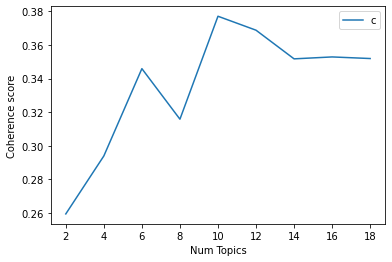

In [38]:
# Show graph
limit=20; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2594
Num Topics = 4  has Coherence Value of 0.2939
Num Topics = 6  has Coherence Value of 0.3459
Num Topics = 8  has Coherence Value of 0.3158
Num Topics = 10  has Coherence Value of 0.3771
Num Topics = 12  has Coherence Value of 0.3688
Num Topics = 14  has Coherence Value of 0.3517
Num Topics = 16  has Coherence Value of 0.3528
Num Topics = 18  has Coherence Value of 0.3519


In [40]:
# Select the model and print the topics
optimal_model = model_list[4]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.056*"business" + 0.044*"plan" + 0.041*"climate" + 0.033*"know" + '
  '0.030*"exxon" + 0.029*"emission" + 0.029*"reveal" + 0.029*"damage" + '
  '0.021*"evil" + 0.020*"add"'),
 (1,
  '0.028*"climate" + 0.028*"oil" + 0.019*"amp" + 0.018*"industry" + '
  '0.017*"company" + 0.016*"change" + 0.013*"gas" + 0.013*"project" + '
  '0.012*"need" + 0.010*"get"'),
 (2,
  '0.051*"climate" + 0.051*"concern" + 0.024*"science" + 0.023*"lie" + '
  '0.020*"worlds_bigg" + 0.018*"lower" + 0.017*"document" + 0.014*"here" + '
  '0.013*"fast" + 0.013*"part"'),
 (3,
  '0.069*"climate" + 0.052*"change" + 0.040*"exxon" + 0.021*"company" + '
  '0.020*"strategy" + 0.019*"emission" + 0.015*"back" + 0.014*"say" + '
  '0.012*"hold" + 0.011*"technology"'),
 (4,
  '0.131*"fuel" + 0.119*"fossil" + 0.080*"pressure" + 0.040*"sue" + '
  '0.037*"climate" + 0.034*"corporation" + 0.027*"end" + 0.027*"crisis" + '
  '0.027*"petition" + 0.027*"year"'),
 (5,
  '0.073*"climate" + 0.063*"oil" + 0.046*"change" + 0.037*"she

In [41]:
# Visualize the optimal topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(optimal_model, corpus, id2word)
vis

/opt/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.095682 -0.040436       1        1  14.365435
8      0.063988  0.046793       2        1  14.299710
9      0.144030  0.032834       3        1  13.876081
1      0.049624  0.073239       4        1  12.975538
5      0.133879  0.047712       5        1  10.494232
6      0.159854  0.006644       6        1   9.880708
4     -0.269552  0.242918       7        1   7.523811
7     -0.140357 -0.127579       8        1   7.022122
0     -0.114664 -0.245799       9        1   5.616304
2     -0.122484 -0.036327      10        1   3.946059, topic_info=          Term         Freq         Total Category  logprob  loglift
56        fuel  2374.000000   2374.000000  Default  30.0000  30.0000
174   activist  2692.000000   2692.000000  Default  29.0000  29.0000
55      fossil  2155.000000   2155.000000  Default  28.0000  28.0000
59    pressure  1340.000000   1340.000000  Default  27.0000  27.0000
1033     board  2080.000000   2080.000000  Default  26.0000  26.0000
...        ...          ...           ...      ...      ...      ...
3      climate   444.043691  14973.090977  Topic10  -2.9674  -0.2856
30      change    81.293658   5821.441594  Topic10  -4.6652  -1.0388
20    emission    66.923359   1398.384037  Topic10  -4.8598   0.1929
795       sell    51.281826    126.353721  Topic10  -5.1260   2.3307
67     company    58.689007   2642.322569  Topic10  -4.9911  -0.5747

[606 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1733      1  0.859628  accountable
1733      2  0.034662  accountable
1733      3  0.034662  accountable
1733     10  0.069325  accountable
64        1  0.240853       action
...     ...       ...          ...
63        8  0.013372         year
63       10  0.008596         year
1488      2  0.977987    years_ago
2197      6  0.937368    york_time
2197      7  0.057390    york_time

[1506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 9, 10, 2, 6, 7, 5, 8, 1, 3])

In [61]:
len(nctext)

21029

In [67]:
len(authorid)

21029

In [63]:
len(lst_author_id)


nctext = tweets['text'].tolist()
tweetid = tweets['id'].tolist()
authorid = tweets['author_id'].tolist()

22576

### Finding the dominant topic in each sentence

In [73]:
def format_topics_sentences(ldamodel=lda_model,
                            corpus=corpus,
                            texts=nctext,
                            tweet_id=tweetid,
                            author_id=authorid,
                            author_name=authorname,
                            author_username=authorusername):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    TweetId = pd.Series(tweet_id)
    AuthorId = pd.Series(author_id)
    AuthorName = pd.Series(author_name)
    AuthorUseranme = pd.Series(author_username)
    
    sent_topics_df = pd.concat([sent_topics_df, contents, TweetId, AuthorId, AuthorName, AuthorUseranme], axis=1)
    #sent_topics_df = pd.concat([sent_topics_df, TweetId], axis=1)
    #sent_topics_df = pd.concat([sent_topics_df, AuthorId], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model,
                                                  corpus=corpus,
                                                  texts=nctext,
                                                  tweet_id=tweetid,
                                                  author_id=authorid,
                                                  author_name=authorname,
                                                  author_username=authorusername)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 
                             'Keywords', 'Text', 'TweetId', 'AuthorId', 'AuthorName','AuthorUsername']

# Show
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text,TweetId,AuthorId,AuthorName,AuthorUsername
0,0,8.0,0.9526,"climate, big, change, oil, crisis, use, downplay, say, company, know","'We are in a climate emergency'December wildfires ravage Colorado https://t.co/sWDkZM4Rvn Sen. Manchin, your Exxon highway bill isn't going 2save our homes or our lives,"" ""Your greed &amp; corruption is not only torching our future It's burning our communities and destroying lives!",1477024401254092800,1009831809855688707,Vammek Opinion,Vammek
1,1,0.0,0.9182,"business, plan, climate, know, exxon, emission, reveal, damage, evil, add","#Oil business knows about the damage that It does, but this business is too much easy and lucrative https://t.co/W7MemjJAA9 #FossilFuels \nExxon’s Plan for Surging Carbon Emissions Revealed in Leaked Documents https://t.co/RFX8meYv11",1476991564803104776,590788952,Robert Pujol i Vives,rpujolvives
2,2,0.0,0.2807,"business, plan, climate, know, exxon, emission, reveal, damage, evil, add",@amywestervelt Your opinion piece concerning climate science alone motivating people to help create political change on Global Warming policy is Spot On. Informing people about the injustices Exxon and Big Oil has perpetrated on us is crucial in inspiring citizens to fight back.,1476962302159060992,1476958634705780736,Megan Robbins,MeganRo50852817
3,3,4.0,0.9471,"fuel, fossil, pressure, sue, climate, corporation, end, crisis, petition, year","Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign this petition to pressure the Senate to END fossil fuel subsidies https://t.co/2A7wLyid3X?",1476954565450903553,47878087,Jennifer Hall,JDHall_35402
4,4,4.0,0.9471,"fuel, fossil, pressure, sue, climate, corporation, end, crisis, petition, year","Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign our petition to pressure the Senate to END fossil fuel subsidies https://t.co/OD7YqPO5SP?",1476922966893948928,1450838788037496836,Dennis Landi,DennisLandi2


In [109]:

url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'

df_dominant_topic['urls'] = df_dominant_topic['Text'].apply(lambda x: re.findall(url_regex, x))

df_url_lst = df_dominant_topic.filter(['Dominant_Topic','TweetId','AuthorId','AuthorName','AuthorUsername','urls'], axis=1)


#remove rows that don't contain urls
df_url_lst = df_url_lst[df_url_lst['urls'].map(lambda d: len(d)) > 0]

df_url_lst.head(10)
#'([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)'
#'https?://(?:[-\w.]|(?:%[\da-fA-F]{2}))+'
#url_0 = [re.findall(url_regex, urls) for urls in topic_0]

<>:1: DeprecationWarning: invalid escape sequence \(
<>:1: DeprecationWarning: invalid escape sequence \(
/var/folders/kg/0ndh6pln2x7b6rpm16twhvpc0000gn/T/ipykernel_48789/3651259747.py:1: DeprecationWarning: invalid escape sequence \(
  url_regex = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


,Dominant_Topic,TweetId,AuthorId,AuthorName,AuthorUsername,urls
0,8.0,1477024401254092800,1009831809855688707,Vammek Opinion,Vammek,[https://t.co/sWDkZM4Rvn]
1,0.0,1476991564803104776,590788952,Robert Pujol i Vives,rpujolvives,"[https://t.co/W7MemjJAA9, https://t.co/RFX8meYv11]"
3,4.0,1476954565450903553,47878087,Jennifer Hall,JDHall_35402,[https://t.co/2A7wLyid3X?]
4,4.0,1476922966893948928,1450838788037496836,Dennis Landi,DennisLandi2,[https://t.co/OD7YqPO5SP?]
5,0.0,1476916783525371911,2843451077,Bob Hill,bobhillbrain,"[https://t.co/o4xvt3yxVm, https://t.co/CGRbN8jm11]"
6,4.0,1476798432949858306,1269149246,SAVE AMERICA,vietthanhsports,[https://t.co/SAKgz7OEZy?]
8,9.0,1476732535572889601,203414131,Jon,ObiWan0001,[https://t.co/ppdezrIN74]
10,3.0,1476719254833618945,1006146920119750657,Connor,connorfx76,[https://t.co/Z46zJmZspE]
12,4.0,1476687897466130434,1618504489,Nelson,NelsonAPike,[https://t.co/1Zk40ByoVK?]
13,0.0,1476675758357729292,2843451077,Bob Hill,bobhillbrain,"[https://t.co/o4xvt3yxVm, https://t.co/CGRbN8jm11]"


In [111]:
df_url_lst.shape

(19517, 6)

In [112]:
#creat multiple rows for the tweet that has multiple urls
df_url = df_url_lst.set_index(['Dominant_Topic','TweetId','AuthorId','AuthorName','AuthorUsername'])['urls'].apply(pd.Series).stack()
df_url = df_url.reset_index()
df_url.columns = ['Topic','TweetId','AuthorId','AuthorName','AuthorUsername','#urls','urls']
df_url.head()

,Topic,TweetId,AuthorId,AuthorName,AuthorUsername,#urls,urls
0,8.0,1477024401254092800,1009831809855688707,Vammek Opinion,Vammek,0,https://t.co/sWDkZM4Rvn
1,0.0,1476991564803104776,590788952,Robert Pujol i Vives,rpujolvives,0,https://t.co/W7MemjJAA9
2,0.0,1476991564803104776,590788952,Robert Pujol i Vives,rpujolvives,1,https://t.co/RFX8meYv11
3,4.0,1476954565450903553,47878087,Jennifer Hall,JDHall_35402,0,https://t.co/2A7wLyid3X?
4,4.0,1476922966893948928,1450838788037496836,Dennis Landi,DennisLandi2,0,https://t.co/OD7YqPO5SP?


In [113]:
df_url.shape

(21423, 7)

In [139]:
#for i in range(10):
    lst = []
    lst.append(




topic_1 = df_url[df_url['Topic'] == 1].pivot_table(columns=['urls'], aggfunc='size').sort_values(ascending=False).head(10)
topic_1

urls
https://t.co/rzE0zAQVa8    20
https://t.co/VrYzunSb4c     7
https://t.co/D7doHYJapU     7
https://t.co/wQD8SQx7lz     5
https://t.co/9XbgTbeJiI     3
https://t.co/qcDVnBP5k0     3
https://t.co/cpMj8PhDKT     2
https://t.co/JfZO79eZzD     2
https://t.co/XlfcRIIMAu     2
https://t.co/P5nqzUFSy1     2
dtype: int64

#export df_url_lst to csv
os.makedirs('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project', exist_ok=True)  
df_url.to_csv('/Users/lavine/Desktop/Terriers!/misinformation project/github/Climate-Change-Misinformation-project/each_topic_urls.csv')  

### Find the most representative document for each topic

In [46]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head(10)

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9357,"business, plan, climate, know, exxon, emission, reveal, damage, evil, add","https://t.co/B4K7DImfmz Exxon-designed “bipartisan” infrastructure plan worsens emissions, but pairing it w/clean energy in Build Back Better neutralizes BIF’s harm &amp; lets us tackle the climate crisis #Reconciliationplan #budget #Budget2021 #budgetBill #BuildBackBetter"
1,1.0,0.9577,"climate, oil, amp, industry, company, change, gas, project, need, get","Oil firms face workforce crunch as renewables beckon -survey. Climate hawks NEVER want to discourage small dollar donations from ""Eddie Exxon in the oil fields"" and ""Eliza Exxon at the gas station"" because they both want better lives and a just transition. https://t.co/iWq5sHkADs"
2,2.0,0.9319,"climate, concern, science, lie, worlds_bigg, lower, document, here, fast, part","Tobacco CEOs were dubbed the Seven Dwarfs when they came and lied to Congress about cigarettes not being addictive.\n\nThe #SlipperySix -- the executives of Exxon, Chevron, Shell, BP, API, and US Chamber -- now lie about their history of climate denial. https://t.co/xZOF3Vmiib"
3,3.0,0.9639,"climate, change, exxon, company, strategy, emission, back, say, hold, technology","Each day, three times a day, Exxon told more than 100,000 Punchbowl subscribers that the company is “working to reduce emissions and help advance climate solutions,” and “advancing climate solutions like carbon capture and storage to help create a lower-carbon energy future.”"
4,4.0,0.9526,"fuel, fossil, pressure, sue, climate, corporation, end, crisis, petition, year","Each year, the government gives over $15 billion in taxpayer-funded subsidies to fossil fuel corporations who contribute to the climate crisis like Exxon. \n\nWill you sign our petition to pressure the Senate to END fossil fuel subsidies https://t.co/QafFuRpbFg? SAVE THE PLANET!"
5,5.0,0.9625,"climate, oil, change, shell, big, chevron, engine, investor, company, day","Big Setbacks Propel Oil Giants Toward ‘Tipping Point’:\n\nA surprising mix of environmentalists, pension fund managers &amp; big money investors have scored startling victories against oil &amp; coal in recent weeks, opening new battle fronts in the climate fight.\n\nhttps://t.co/xpNUv0hr4T https://t.co/rZwJvD1ZDu"
6,6.0,0.9526,"activist, climate, board, investor, new, win, shareholder, least, push, director",Exxon's management was just dealt a stunning defeat by the election of at least two board candidates nominated by activist investors who pledged to steer the company away from oil and gas and toward cleaner energy: https://t.co/S6BphWPxjx\n #ClimateAction
7,7.0,0.9500,"climate, video, push, catch, lobbyist, plan, talk, landmark, exxon, bid",In Your Facebook Feed: Oil Industry Pushback Against Biden Climate Plans: The messages take aim at Democrats by name as part of a broad effort to undermine landmark climate legislation that now hangs in the balance… https://t.co/RNjsSY1PXo #GlobalWarming #GreenhouseGasEmissions
8,8.0,0.9571,"climate, big, change, oil, crisis, use, downplay, say, company, know",They could have stopped climate change 40 years ago\nExxon Knew about Climate Change almost 40 years ago\n\nA new investigation shows the oil company understood the science before it became a public issue and spent millions to promote misinformation https://t.co/FtMKjcDsPX
9,9.0,0.9537,"climate, seat, oil, change, vote, board, giant, fight, effort, action","In 1982, Exxon predicted the future evolution of our climate. Blue lines are Exxon's 1982 predictions while orange dots are actual observations. They pretty much nailed the future evolution of our climate. Exxon most definitely knew.\nhttps://t.co/Fp0JQGw5MT"


### Topic distribution across documents

In [47]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics.head(10)

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,8.0,"climate, big, change, oil, crisis, use, downplay, say, company, know",995.0,0.0473
1.0,0.0,"business, plan, climate, know, exxon, emission, reveal, damage, evil, add",2630.0,0.1251
2.0,0.0,"business, plan, climate, know, exxon, emission, reveal, damage, evil, add",589.0,0.0280
3.0,4.0,"fuel, fossil, pressure, sue, climate, corporation, end, crisis, petition, year",3163.0,0.1504
4.0,4.0,"fuel, fossil, pressure, sue, climate, corporation, end, crisis, petition, year",984.0,0.0468
5.0,0.0,"business, plan, climate, know, exxon, emission, reveal, damage, evil, add",2430.0,0.1156
6.0,4.0,"fuel, fossil, pressure, sue, climate, corporation, end, crisis, petition, year",2373.0,0.1128
7.0,1.0,"climate, oil, amp, industry, company, change, gas, project, need, get",1615.0,0.0768
8.0,9.0,"climate, seat, oil, change, vote, board, giant, fight, effort, action",3142.0,0.1494
9.0,9.0,"climate, seat, oil, change, vote, board, giant, fight, effort, action",3108.0,0.1478
